In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
dataset = pd.read_csv('주유소_평균판매가격_제품별.csv', encoding='cp949')

In [2]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

In [73]:
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col = [col for col in list(train_df.columns) if col not in not_col]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [91]:
def FE(dataset):
    # 년, 월, 일
    data = dataset.__deepcopy__()
    data['year'] = data['구분'].str.split('년').str[0]
    data['month'] = data['구분'].str.split('년').str[1].str.split('월').str[0]
    data['day'] = data['구분'].str.split('년').str[1].str.split('월').str[1].str.split('일').str[0]
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    data.drop('구분', axis=1, inplace=True)
    
    data['year'] = data['year'].astype('int')
    data['month'] = data['month'].astype('int')
    data['day'] = data['day'].astype('int')
    
    return data
data = FE(dataset)
data['target'] = data['자동차용경유']

In [92]:
train = data[data['year'] != 2024]
test = data[data['year'] == 2024]

In [93]:
window_size = 30
forcast_size= 1
batch_size = 32
targets = '자동차용경유'
# date = ['date']
nc = ['date', 'target']

train_df_fe, test_df_fe, mean_, std_ = standardization(train, test, nc, targets)
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, 'date', 'target')
test_x, test_y, test_date = time_slide_df(test_df_fe.reset_index(), window_size, forcast_size, 'date', 'target')

train_ds = Data(train_x[:-365], train_y[:-365])
valid_ds = Data(train_x[-365:], train_y[-365:])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[-365:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

자동차용경유
['고급휘발유', '보통휘발유', '자동차용경유', '실내등유', 'year', 'month', 'day']


C:\Users\이음\AppData\Local\Temp\ipykernel_26948\3319968104.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.68263846 -1.68263846 -1.68263846 ...  1.62262651  1.62262651
  1.62262651]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train_df_.loc[:, x] = (train_df_[x] - mean) / std
C:\Users\이음\AppData\Local\Temp\ipykernel_26948\3319968104.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.84297751 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751
 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751
 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751
 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751
 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751
 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751 1.84297751
 1.84297751 1

In [95]:
train_y

array([[1731.62],
       [1745.05],
       [1753.52],
       ...,
       [1497.25],
       [1495.66],
       [1495.21]], dtype=float32)

In [96]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [97]:
train_y

array([[1731.62],
       [1745.05],
       [1753.52],
       ...,
       [1497.25],
       [1495.66],
       [1495.21]], dtype=float32)

In [129]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|▍         | 2/50 [00:00<00:10,  4.68it/s]

valid_loss=1036.226, test_los365.195, Model Save
epoch = 1, train_loss : 881.561, valid_loss : 1036.226, test_loss : 365.195
valid_loss=574.222, test_los107.775, Model Save
epoch = 2, train_loss : 432.225, valid_loss : 574.222, test_loss : 107.775


  8%|▊         | 4/50 [00:00<00:08,  5.48it/s]

valid_loss=272.311, test_los98.175, Model Save
epoch = 3, train_loss : 234.318, valid_loss : 272.311, test_loss : 98.175
valid_loss=193.611, test_los34.755, Model Save
epoch = 4, train_loss : 149.448, valid_loss : 193.611, test_loss : 34.755


 12%|█▏        | 6/50 [00:01<00:07,  6.27it/s]

valid_loss=94.992, test_los17.321, Model Save
epoch = 5, train_loss : 100.596, valid_loss : 94.992, test_loss : 17.321
valid_loss=63.181, test_los12.747, Model Save
epoch = 6, train_loss : 66.795, valid_loss : 63.181, test_loss : 12.747


 16%|█▌        | 8/50 [00:01<00:06,  6.50it/s]

valid_loss=44.212, test_los10.362, Model Save
epoch = 7, train_loss : 59.471, valid_loss : 44.212, test_loss : 10.362
epoch = 8, train_loss : 48.256, valid_loss : 48.506, test_loss : 33.967


 20%|██        | 10/50 [00:01<00:05,  6.78it/s]

valid_loss=27.408, test_los7.590, Model Save
epoch = 9, train_loss : 50.711, valid_loss : 27.408, test_loss : 7.590
epoch = 10, train_loss : 38.444, valid_loss : 44.985, test_loss : 37.227


 24%|██▍       | 12/50 [00:01<00:05,  6.44it/s]

valid_loss=23.732, test_los5.655, Model Save
epoch = 11, train_loss : 33.394, valid_loss : 23.732, test_loss : 5.655
valid_loss=18.811, test_los4.464, Model Save
epoch = 12, train_loss : 34.902, valid_loss : 18.811, test_loss : 4.464


 28%|██▊       | 14/50 [00:02<00:05,  6.08it/s]

epoch = 13, train_loss : 27.817, valid_loss : 33.707, test_loss : 14.583
valid_loss=15.016, test_los3.631, Model Save
epoch = 14, train_loss : 28.429, valid_loss : 15.016, test_loss : 3.631


 32%|███▏      | 16/50 [00:02<00:05,  6.74it/s]

valid_loss=12.740, test_los4.940, Model Save
epoch = 15, train_loss : 23.107, valid_loss : 12.740, test_loss : 4.940
epoch = 16, train_loss : 21.190, valid_loss : 25.328, test_loss : 11.686


 36%|███▌      | 18/50 [00:02<00:04,  6.97it/s]

epoch = 17, train_loss : 20.783, valid_loss : 15.632, test_loss : 5.605
epoch = 18, train_loss : 18.483, valid_loss : 17.517, test_loss : 7.541


 40%|████      | 20/50 [00:03<00:04,  6.72it/s]

valid_loss=10.727, test_los3.722, Model Save
epoch = 19, train_loss : 16.416, valid_loss : 10.727, test_loss : 3.722
valid_loss=10.271, test_los3.522, Model Save
epoch = 20, train_loss : 17.875, valid_loss : 10.271, test_loss : 3.522


 44%|████▍     | 22/50 [00:03<00:04,  6.50it/s]

valid_loss=8.895, test_los2.966, Model Save
epoch = 21, train_loss : 12.876, valid_loss : 8.895, test_loss : 2.966
valid_loss=6.176, test_los1.871, Model Save
epoch = 22, train_loss : 15.354, valid_loss : 6.176, test_loss : 1.871


 48%|████▊     | 24/50 [00:03<00:04,  6.02it/s]

epoch = 23, train_loss : 13.358, valid_loss : 7.034, test_loss : 2.236
valid_loss=5.469, test_los1.621, Model Save
epoch = 24, train_loss : 13.762, valid_loss : 5.469, test_loss : 1.621


 52%|█████▏    | 26/50 [00:04<00:03,  7.09it/s]

valid_loss=5.235, test_los2.291, Model Save
epoch = 25, train_loss : 13.410, valid_loss : 5.235, test_loss : 2.291
valid_loss=4.718, test_los1.708, Model Save
epoch = 26, train_loss : 9.514, valid_loss : 4.718, test_loss : 1.708


 56%|█████▌    | 28/50 [00:04<00:02,  7.68it/s]

valid_loss=4.486, test_los1.486, Model Save
epoch = 27, train_loss : 11.563, valid_loss : 4.486, test_loss : 1.486
valid_loss=4.380, test_los1.445, Model Save
epoch = 28, train_loss : 9.236, valid_loss : 4.380, test_loss : 1.445


 60%|██████    | 30/50 [00:04<00:02,  6.76it/s]

epoch = 29, train_loss : 11.593, valid_loss : 15.557, test_loss : 10.484
epoch = 30, train_loss : 9.432, valid_loss : 20.758, test_loss : 19.521


 64%|██████▍   | 32/50 [00:04<00:02,  6.82it/s]

epoch = 31, train_loss : 22.831, valid_loss : 15.716, test_loss : 14.395
epoch = 32, train_loss : 8.777, valid_loss : 4.702, test_loss : 2.079


 68%|██████▊   | 34/50 [00:05<00:02,  6.43it/s]

epoch = 33, train_loss : 8.279, valid_loss : 5.392, test_loss : 3.996
epoch = 34, train_loss : 7.975, valid_loss : 6.541, test_loss : 3.740


 72%|███████▏  | 36/50 [00:05<00:02,  5.99it/s]

valid_loss=4.204, test_los2.262, Model Save
epoch = 35, train_loss : 9.079, valid_loss : 4.204, test_loss : 2.262
valid_loss=4.010, test_los1.624, Model Save
epoch = 36, train_loss : 8.635, valid_loss : 4.010, test_loss : 1.624


 76%|███████▌  | 38/50 [00:05<00:01,  6.08it/s]

valid_loss=3.325, test_los1.465, Model Save
epoch = 37, train_loss : 9.197, valid_loss : 3.325, test_loss : 1.465
epoch = 38, train_loss : 9.511, valid_loss : 9.165, test_loss : 6.014


 78%|███████▊  | 39/50 [00:06<00:01,  6.00it/s]

epoch = 39, train_loss : 8.326, valid_loss : 7.778, test_loss : 6.574


 80%|████████  | 40/50 [00:06<00:01,  5.61it/s]

epoch = 40, train_loss : 7.544, valid_loss : 4.479, test_loss : 3.302


 84%|████████▍ | 42/50 [00:06<00:01,  5.17it/s]

epoch = 41, train_loss : 7.543, valid_loss : 6.953, test_loss : 4.489
valid_loss=2.210, test_los0.900, Model Save
epoch = 42, train_loss : 7.933, valid_loss : 2.210, test_loss : 0.900


 88%|████████▊ | 44/50 [00:06<00:00,  6.28it/s]

epoch = 43, train_loss : 8.520, valid_loss : 2.297, test_loss : 0.902
valid_loss=2.083, test_los0.863, Model Save
epoch = 44, train_loss : 9.767, valid_loss : 2.083, test_loss : 0.863


 92%|█████████▏| 46/50 [00:07<00:00,  6.84it/s]

epoch = 45, train_loss : 8.571, valid_loss : 3.871, test_loss : 2.393
epoch = 46, train_loss : 9.005, valid_loss : 5.234, test_loss : 3.118


 96%|█████████▌| 48/50 [00:07<00:00,  7.19it/s]

epoch = 47, train_loss : 7.023, valid_loss : 15.314, test_loss : 14.131
epoch = 48, train_loss : 5.752, valid_loss : 2.442, test_loss : 0.984


100%|██████████| 50/50 [00:07<00:00,  6.41it/s]

epoch = 49, train_loss : 6.674, valid_loss : 5.345, test_loss : 3.332
epoch = 50, train_loss : 5.343, valid_loss : 3.376, test_loss : 1.716


In [124]:
from tqdm import tqdm

train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
NLinear_model = LTSF_NLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            # kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(NLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    NLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = NLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    NLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = NLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = NLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(NLinear_model, 'NLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        nlinear_best_epoch = epoch
        nlinear_best_train_loss = np.mean(loss_list)
        nlinear_best_valid_loss = np.mean(valid_loss.item())
        nlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|▍         | 2/50 [00:00<00:03, 12.12it/s]

valid_loss=8.679, test_los1.991, Model Save
epoch = 1, train_loss : 259.305, valid_loss : 8.679, test_loss : 1.991
valid_loss=6.517, test_los1.813, Model Save
epoch = 2, train_loss : 7.219, valid_loss : 6.517, test_loss : 1.813
valid_loss=5.182, test_los1.554, Model Save
epoch = 3, train_loss : 6.290, valid_loss : 5.182, test_loss : 1.554


 12%|█▏        | 6/50 [00:00<00:03, 12.23it/s]

valid_loss=4.967, test_los1.153, Model Save
epoch = 4, train_loss : 5.335, valid_loss : 4.967, test_loss : 1.153
valid_loss=3.483, test_los1.034, Model Save
epoch = 5, train_loss : 4.612, valid_loss : 3.483, test_loss : 1.034
valid_loss=2.928, test_los0.908, Model Save
epoch = 6, train_loss : 4.078, valid_loss : 2.928, test_loss : 0.908


 16%|█▌        | 8/50 [00:00<00:03, 12.21it/s]

valid_loss=2.359, test_los0.916, Model Save
epoch = 7, train_loss : 3.699, valid_loss : 2.359, test_loss : 0.916
epoch = 8, train_loss : 3.442, valid_loss : 2.481, test_loss : 0.763
valid_loss=1.917, test_los0.808, Model Save
epoch = 9, train_loss : 3.352, valid_loss : 1.917, test_loss : 0.808


 24%|██▍       | 12/50 [00:00<00:03, 11.96it/s]

valid_loss=1.893, test_los0.847, Model Save
epoch = 10, train_loss : 3.206, valid_loss : 1.893, test_loss : 0.847
valid_loss=1.830, test_los0.722, Model Save
epoch = 11, train_loss : 3.231, valid_loss : 1.830, test_loss : 0.722
valid_loss=1.757, test_los0.783, Model Save
epoch = 12, train_loss : 3.191, valid_loss : 1.757, test_loss : 0.783


 28%|██▊       | 14/50 [00:01<00:02, 12.05it/s]

valid_loss=1.670, test_los0.766, Model Save
epoch = 13, train_loss : 3.301, valid_loss : 1.670, test_loss : 0.766
valid_loss=1.629, test_los0.719, Model Save
epoch = 14, train_loss : 3.147, valid_loss : 1.629, test_loss : 0.719
epoch = 15, train_loss : 3.077, valid_loss : 1.751, test_loss : 0.711


 36%|███▌      | 18/50 [00:01<00:02, 12.21it/s]

epoch = 16, train_loss : 3.141, valid_loss : 1.706, test_loss : 0.809
epoch = 17, train_loss : 3.115, valid_loss : 1.769, test_loss : 0.733
epoch = 18, train_loss : 3.126, valid_loss : 1.735, test_loss : 0.763


 40%|████      | 20/50 [00:01<00:02, 12.29it/s]

valid_loss=1.579, test_los0.754, Model Save
epoch = 19, train_loss : 3.064, valid_loss : 1.579, test_loss : 0.754
epoch = 20, train_loss : 3.126, valid_loss : 3.611, test_loss : 0.993
valid_loss=1.560, test_los0.738, Model Save
epoch = 21, train_loss : 3.234, valid_loss : 1.560, test_loss : 0.738


 48%|████▊     | 24/50 [00:01<00:02, 12.42it/s]

epoch = 22, train_loss : 2.977, valid_loss : 4.712, test_loss : 1.246
epoch = 23, train_loss : 3.027, valid_loss : 1.625, test_loss : 0.679
epoch = 24, train_loss : 3.282, valid_loss : 2.724, test_loss : 0.841


 52%|█████▏    | 26/50 [00:02<00:01, 12.24it/s]

epoch = 25, train_loss : 2.887, valid_loss : 2.516, test_loss : 0.903
valid_loss=1.491, test_los0.711, Model Save
epoch = 26, train_loss : 2.833, valid_loss : 1.491, test_loss : 0.711
epoch = 27, train_loss : 3.081, valid_loss : 1.845, test_loss : 0.875


 60%|██████    | 30/50 [00:02<00:01, 12.40it/s]

epoch = 28, train_loss : 2.752, valid_loss : 1.690, test_loss : 0.690
valid_loss=1.445, test_los0.697, Model Save
epoch = 29, train_loss : 2.901, valid_loss : 1.445, test_loss : 0.697
epoch = 30, train_loss : 2.858, valid_loss : 1.495, test_loss : 0.667


 64%|██████▍   | 32/50 [00:02<00:01, 12.42it/s]

epoch = 31, train_loss : 2.818, valid_loss : 1.487, test_loss : 0.690
epoch = 32, train_loss : 2.796, valid_loss : 2.777, test_loss : 1.181
epoch = 33, train_loss : 2.870, valid_loss : 1.532, test_loss : 0.658


 72%|███████▏  | 36/50 [00:02<00:01, 12.54it/s]

epoch = 34, train_loss : 2.872, valid_loss : 1.524, test_loss : 0.761
epoch = 35, train_loss : 2.944, valid_loss : 1.765, test_loss : 0.686
epoch = 36, train_loss : 2.687, valid_loss : 5.431, test_loss : 1.408


 76%|███████▌  | 38/50 [00:03<00:00, 12.24it/s]

epoch = 37, train_loss : 2.899, valid_loss : 1.707, test_loss : 0.840
epoch = 38, train_loss : 2.830, valid_loss : 1.493, test_loss : 0.656
epoch = 39, train_loss : 2.732, valid_loss : 1.563, test_loss : 0.713


 84%|████████▍ | 42/50 [00:03<00:00, 12.33it/s]

epoch = 40, train_loss : 2.950, valid_loss : 7.218, test_loss : 2.373
epoch = 41, train_loss : 2.575, valid_loss : 1.985, test_loss : 0.942
epoch = 42, train_loss : 2.701, valid_loss : 2.647, test_loss : 1.125


 88%|████████▊ | 44/50 [00:03<00:00, 12.38it/s]

valid_loss=1.357, test_los0.683, Model Save
epoch = 43, train_loss : 2.675, valid_loss : 1.357, test_loss : 0.683
epoch = 44, train_loss : 2.783, valid_loss : 1.865, test_loss : 0.755
epoch = 45, train_loss : 2.652, valid_loss : 1.530, test_loss : 0.799


 96%|█████████▌| 48/50 [00:03<00:00, 12.48it/s]

epoch = 46, train_loss : 2.717, valid_loss : 1.451, test_loss : 0.739
epoch = 47, train_loss : 2.809, valid_loss : 1.358, test_loss : 0.696
epoch = 48, train_loss : 3.419, valid_loss : 4.031, test_loss : 1.140


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]

epoch = 49, train_loss : 2.452, valid_loss : 2.153, test_loss : 0.758
epoch = 50, train_loss : 2.548, valid_loss : 4.351, test_loss : 1.172


In [132]:
dlst = []
with torch.no_grad():
    for data, target in test_dl:
        output = DLinear_model(data)
        dlst.append(output)

In [125]:
nlst = []
with torch.no_grad():
    for data, target in test_dl:
        output = NLinear_model(data)
        nlst.append(output)

In [126]:
loss_test = test_y.reshape(-1) - nlst[0].reshape(-1).tolist()

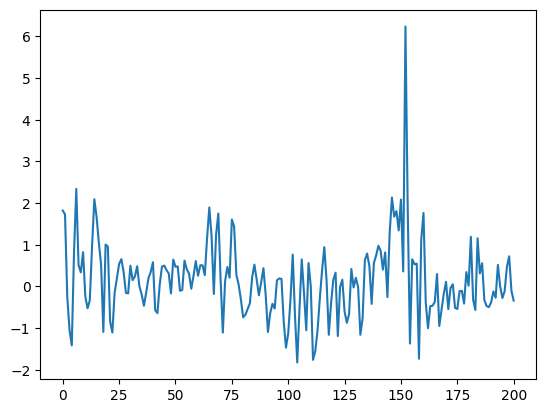

In [120]:
plt.plot(loss_test)

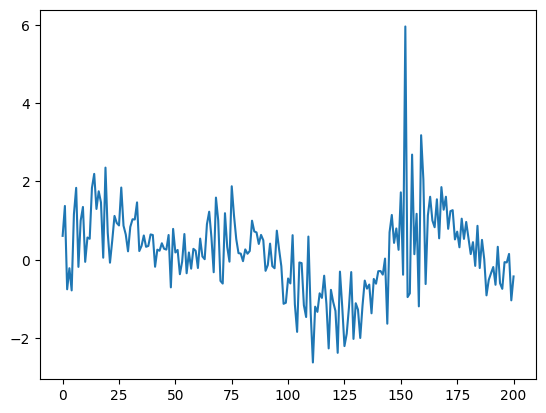

In [127]:
plt.plot(loss_test)


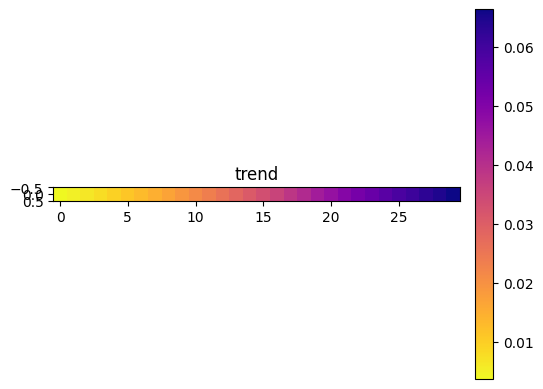

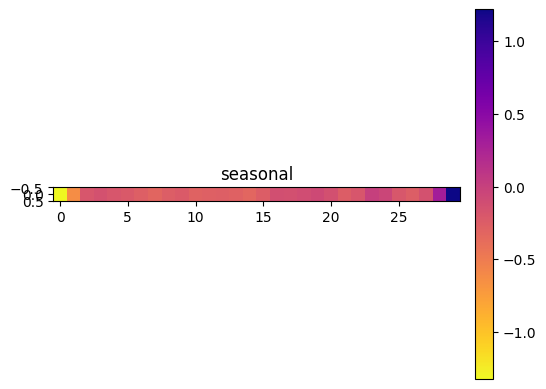

In [128]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()

In [123]:
test

,고급휘발유,보통휘발유,자동차용경유,실내등유,year,month,day,date,target
5739,1862.82,1578.54,1493.91,1371.40,2024,1,1,2024-01-01,1493.91
5740,1862.40,1577.46,1492.73,1370.70,2024,1,2,2024-01-02,1492.73
5741,1861.02,1575.89,1490.43,1369.50,2024,1,3,2024-01-03,1490.43
5742,1859.51,1574.52,1488.53,1368.20,2024,1,4,2024-01-04,1488.53
5743,1858.96,1573.43,1487.12,1367.12,2024,1,5,2024-01-05,1487.12
...,...,...,...,...,...,...,...,...,...
5965,1943.97,1695.28,1533.09,1351.41,2024,8,14,2024-08-14,1533.09
5966,1943.15,1694.46,1532.19,1350.97,2024,8,15,2024-08-15,1532.19
5967,1943.09,1693.88,1531.77,1351.06,2024,8,16,2024-08-16,1531.77
5968,1939.98,1692.92,1530.64,1350.89,2024,8,17,2024-08-17,1530.64


In [ ]:
window_size = 72
forcast_size= 24
batch_size = 32
targets = '전력사용량(kWh)'
date = 'date_time'

train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'date_time', targets)
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)

train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[1000:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)
